In [1]:
from time import time
import lightgbm as lgb
import numpy as np
import sys
# sys.path.append('..\Python Scripts\pipeline')
import warnings
warnings.filterwarnings('ignore') 
import seaborn as sns
from sklearn import preprocessing
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import pickle
from sklearn.model_selection import KFold, TimeSeriesSplit
from scipy.stats import uniform
import datetime
from sklearn.ensemble import RandomForestClassifier
import lightgbm
from scipy import stats
# from hyperopt import hp, tpe
# from hyperopt.fmin import fmin
from sklearn.model_selection import cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, \
cross_val_score, GridSearchCV, validation_curve, KFold, GroupKFold
from sklearn.metrics import roc_auc_score
import seaborn as sns
%matplotlib inline
import gc

In [2]:
def num_cat(df):
    '''
    Функция возвращает куски исходного датафрейма. Куски состоят из категориальных фич и из числовых
    '''
    categorical_features = df.select_dtypes(include = ["object"]).columns
    numerical_features = df.select_dtypes(exclude = ["object"]).columns
    if 'target' in numerical_features:
        numerical_features = numerical_features.drop('target')
    print("Numerical features : " + str(len(numerical_features)))
    
    print("Categorical features : " + str(len(categorical_features)))

    df_num = df[numerical_features]
    df_cat = df[categorical_features]
    return df_num, df_cat
def missing_values_table(df):
    '''
    Функция возвращает таблицу с количеством и долей пропущенных значений в датафрейме
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")
    return mis_val_table_ren_columns
def reduce_memory_usage(df):
    '''
    iterate through all the columns of a dataframe and modify the data type
    to reduce memory usage.
    '''
    start_mem = df.memory_usage().sum()/1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if (col_type != object) & (col_type != 'datetime64[ns]'):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum()/1024**2
    print('Memory usage: Before|{:.2f} MB || After|{:.2f} MB || Decreased|{:.1f}%'.format(start_mem, end_mem, 100*(1 - end_mem/start_mem)))
    
    return df 
def fast_validate_kfold(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))

    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        100,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=200,
                        early_stopping_rounds=200)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
    plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return clf, feature_importances, preds/folds.n_splits
def fast_estimation(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))
    oof_list = []
    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
#         print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        100,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=200,
                        early_stopping_rounds=200)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        
        oof_list.append(roc_auc_score(y.iloc[test_idx], oof[test_idx]))
        
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

#         print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
#     print('Training has finished.')
#     print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

#     feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


#     plt.figure(figsize=(16, 16))
#     sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
#     plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return roc_auc_score(y, oof)
def submission_validate_kfold(test, X, y, params):
    preds = np.zeros(len(test))
    oof = np.zeros(len(X))

    folds = KFold(n_splits=5, shuffle=False)

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    print('Start')
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):

        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])

        clf = lgb.train(params,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds=500)

        preds += clf.predict(test)
        oof[test_idx] = clf.predict(X.iloc[test_idx])
        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('OOF AUC:', roc_auc_score(y, oof))
    print('-' * 30)

    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(folds.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')


    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(50), x='average', y='feature');
    plt.title('50 TOP feature importance over {} folds average'.format(folds.n_splits));
    
    return clf, feature_importances, preds/folds.n_splits
def outliers(i, df, col):
    scaled = StandardScaler().fit_transform(df[col].dropna()[:, np.newaxis])
    
    low_range = scaled[scaled[:,0].argsort()][:10]
    high_range= scaled[scaled[:,0].argsort()][-10:]
    if len(np.unique(low_range)) >= 2 or len(np.unique(high_range)) >= 2:
        print(i, col)
        print('outer range (low) of the distribution:')
        print(low_range)
        print('\nouter range (high) of the distribution:')
        print(high_range)
        print('\n')

        return col, (high_range[-1]/high_range[0])[0], (low_range[-1]/low_range[0])[0]
def kde_target(var_name, df):    
    corr = df['isFraud'].corr(df[var_name])
    avg_repaid = df.loc[df['isFraud'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['isFraud'] == 1, var_name].median()
    
    plt.figure(figsize = (12, 9))
    
    sns.kdeplot(df.loc[df['isFraud'] == 0, var_name], label = 'isFraud == 0')
    sns.kdeplot(df.loc[df['isFraud'] == 1, var_name], label = 'isFraud == 1')
    
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title('%s Distribution' % var_name)
    plt.legend()
    
    print('The correlation between %s and the isFraud is %0.4f' % (var_name, corr))
def check_outliers(flag, df, col):
    if flag == 'train':
        sns.distplot(df[col].dropna())
        kde_target(col, df)
    
    else:
        pass        
    return df[col].value_counts().sort_index()
def time_series_validation(X, y, params):
    folds = TimeSeriesSplit(n_splits=5)

    aucs = list()
    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()
    for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
        clf = lgb.train(params, trn_data, 10000, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds=500)

        feature_importances['fold_{}'.format(fold + 1)] = clf.feature_importance()
        aucs.append(clf.best_score['valid_1']['auc'])

        print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time() - start_time))))
    print('-' * 30)
    print('Training has finished.')
    print('Total training time is {}'.format(str(datetime.timedelta(seconds=time() - training_start_time))))
    print('Mean AUC:', np.mean(aucs))
    print('-' * 30)

In [4]:
# c8 = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\NewId\C8_agg.pkl')
# c5 = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\NewId\C5_agg.pkl')
# tramt = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\NewId\TransactionAmt_agg.pkl')
# train = pd.read_pickle(data_path + 'train_09457_with_additions.pkl')
# test = pd.read_pickle(data_path + 'test_09457_with_additions.pkl')
# train = train.join(c8.loc[train_idx])
# train = train.join(c5.loc[train_idx])
# train = train.join(tramt.loc[train_idx])
# test = test.join(tramt.loc[test_idx])
# y = pd.read_pickle(data_path + 'y.pkl')


In [21]:
# aggs = pd.DataFrame(index=train.index)
# for item in ['dist1_aggby_new_card_id.pkl',
#     'C10_aggby_new_card_id.pkl',
#  'C11_aggby_new_card_id.pkl',
#  'C12_aggby_new_card_id.pkl',
#  'C13_aggby_new_card_id.pkl',
#  'C14_aggby_new_card_id.pkl',
#  'C1_aggby_new_card_id.pkl',
#  'C2_aggby_new_card_id.pkl',
#  'C3_aggby_new_card_id.pkl',
#  'C4_aggby_new_card_id.pkl',
#  'C5_aggby_new_card_id.pkl',
#  'C6_aggby_new_card_id.pkl',
#  'C7_aggby_new_card_id.pkl',
#  'C8_aggby_new_card_id.pkl',
#  'C9_aggby_new_card_id.pkl',
#  'D10_aggby_new_card_id.pkl',
#  'D11_aggby_new_card_id.pkl',
#  'D12_aggby_new_card_id.pkl',
#  'D13_aggby_new_card_id.pkl',
#  'D14_aggby_new_card_id.pkl',
#  'D15_aggby_new_card_id.pkl',
#  'D1_aggby_new_card_id.pkl',
#  'D2_aggby_new_card_id.pkl',
#  'D3_aggby_new_card_id.pkl',
#  'D4_aggby_new_card_id.pkl',
#  'D5_aggby_new_card_id.pkl',
#  'D6_aggby_new_card_id.pkl',
#  'D7_aggby_new_card_id.pkl',
#  'D8_aggby_new_card_id.pkl',
#  'D9_aggby_new_card_id.pkl']:
#     temp = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\NewId' + '//' + item)
#     aggs = aggs.join(temp)
# #     temp = pd.merge(train[[]], temp, how='left', left_index=True, right_index=True)
# #     test = pd.merge(test, temp, how='left', left_index=True, right_index=True)

# aggs = aggs.join(y)

# def individual_gini(i, df, feature):
#     print(i, ' feature: ', feature)
#     df = df.replace(-np.inf, np.nan)
#     df = df.replace(np.inf, np.nan)
#     df = df.fillna(-999)
    
#     if df[feature].dtypes == 'O':
#         x = pd.get_dummies(df[feature]).values
#         obvious_gini = 0
#     else:
# #         print('\t  Counting obvious gini...')
#         x = df[feature].values.reshape(-1, 1)    
#         obvious_gini = round(abs(roc_auc_score(df.isFraud, x) * 2 - 1), 3)

# #     print('\t  Now count gini using decision tree')    
#     parameters = {'min_weight_fraction_leaf': [0.01, 0.025, 0.05, 0.1]}
#     param_dist = {'min_weight_fraction_leaf': np.random.uniform(0.001, 0.1, 4) }
#     dt = DecisionTreeClassifier(random_state=1)
        
#     cv = StratifiedKFold(3, random_state=1)
#     clf = GridSearchCV(dt, parameters,cv=cv,scoring='roc_auc', n_jobs=30)
#     print('\t  Run grid search...')
# #     clf = RandomizedSearchCV(dt, param_distributions=param_dist, cv=cv, verbose=0, n_jobs=10, scoring='roc_auc')
#     clf.fit(x, df.isFraud)
    
#     true_gini = round(abs(clf.best_score_ * 2 - 1), 3)
#     print('\t  True gini is ', true_gini)
#     print('\t  Clf is fitted!\n-------------------------------------------')
    
#     return max(obvious_gini, true_gini), obvious_gini, true_gini, obvious_gini > true_gini

# df_gini = pd.DataFrame(index = aggs.columns.values, columns = ['max_gini', 'obvious', 'true_gini', 'obvious_is_max'])

# for i, col in enumerate(aggs.columns):
#     df_gini.loc[[col], ['max_gini', 'obvious', 'true_gini', 'obvious_is_max']] = individual_gini(i, aggs, col)

# df_gini['roc'] = 0.5*(df_gini['max_gini']+1)

# df_gini06 = df_gini[df_gini['roc'] > 0.67].drop('isFraud')

# df_gini06.shape

# corraggs = aggs[df_gini06.index.tolist()].corr()

# corraggs08 = corraggs[corraggs>0.86]

# corraggs08.dropna(how='all', axis=0, inplace=True)
# corraggs08.dropna(how='all', axis=1, inplace=True)

# df_num_corrs = pd.DataFrame(columns = ['var1', 'var2', 'corr'])

# for k, i in enumerate(corraggs08.index):
#     for j in corraggs08.columns[k:]:
#         if corraggs08.loc[i, j] > 0:
#             df_temp = pd.DataFrame(columns = ['var1', 'var2', 'corr'], data = [[i, j, corraggs08.loc[i, j]]])
#             df_num_corrs = df_num_corrs.append(df_temp, ignore_index=True)
# df_num_corrs.sort_values(by='corr', inplace=True, ascending=False)

# to_drop_num = []
# log = []
# for i in df_num_corrs.values:
#     v1 = i[0]
#     v2 = i[1]

#     if df_gini.loc[v1, 'max_gini'] > df_gini.loc[v2, 'max_gini'] :
#         var_to_drop = v2
#     else:
#         var_to_drop = v1       
#     var_to_leave = v2 if (v1==var_to_drop) else v1
#     log.append([var_to_drop, var_to_leave, i[2]])
#     to_drop_num.append(var_to_drop)
# log = pd.DataFrame(columns=['drop', 'leave', 'corr'], data=log)



# aggsdrop = list(set(log[log['corr'] != 1]['drop']))

# dropgini = df_gini[df_gini['roc'] < 0.67].index.tolist()

# todrop = set(aggsdrop) | set(dropgini)

# df_gini.loc[aggs.drop(todrop, axis=1).columns]

# goodaggs = aggs.drop(list(todrop) + ['isFraud'], axis=1)

# # goodaggs.drop([x for x in goodaggs.columns if 'C5' in x or 'C8' in x], axis=1, inplace=True)

# goodaggs

# goodaggs.to_csv('goodaggs_14.csv')

# # df_gini.to_pickle('ind_gini_aggs.pkl')

# l=[]
# for x in goodaggs.columns:
#     l.append(x[:3])

# set(l)

# goodaggs.columns

In [21]:
main_path = r'../..'
data_path = main_path+'/data/'

%load_ext autoreload
%autoreload 2
import sys
sys.path.append(main_path)
from BayDS.lib.training import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# data = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\full-fe-2809-2-labelenc\label_encoded_data.pkl')
data = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\Test\label_encoded_data.pkl')

train = data[data['isFraud'] != -1]
test = data[data['isFraud'] == -1].drop('isFraud', axis=1)
y = data[data['isFraud'] != -1]['isFraud']

del data
gc.collect()

train_idx = train.index
test_idx = test.index

cols = "TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,M1,M2,M3,M4,M5,M6,M7,M8,M9".split(",")
train_test = train[cols].append(test[cols])

for col in "ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14".split(","):
    col_count = train_test.groupby(col)['TransactionDT'].count()
    train[col+'_count'] = train[col].map(col_count)
    test[col+'_count'] = test[col].map(col_count)
#     print(col,test[col].map(lambda train:0 if train in s else 1).sum())


for col in "card1,card2,card5,addr1,addr2".split(","):
    col_count = train_test.groupby(col)['TransactionAmt'].mean()
    train[col+'_amtcount'] = train[col].map(col_count)
    test[col+'_amtcount'] = test[col].map(col_count)
    col_count1 = train_test[train_test['C5'] == 0].groupby(col)['C5'].count()
    col_count2 = train_test[train_test['C5'] != 0].groupby(col)['C5'].count()
    train[col+'_C5count'] = train[col].map(col_count2) / (train[col].map(col_count1) + 0.01)
    test[col+'_C5count'] = test[col].map(col_count2) / (test[col].map(col_count1) + 0.01)
    
del train_test
gc.collect()


train.drop([x for x in train.columns if 'by_card_id_ws' in x], axis=1, inplace=True)
test.drop([x for x in test.columns if 'by_card_id_ws' in x], axis=1, inplace=True)

train.drop(['Date', 'TransactionDT'], axis=1, inplace=True)
test.drop(['Date', 'TransactionDT'], axis=1, inplace=True)

train.drop(['DT_W', 'DT_D'] , axis=1, inplace=True)
test.drop(['DT_W', 'DT_D'] , axis=1, inplace=True)

train['start_date'] = pd.to_timedelta(pd.to_datetime(train['start_date'])).map(lambda x: x.days)
test['start_date'] = pd.to_timedelta(pd.to_datetime(test['start_date'])).map(lambda x: x.days)

for x in train.columns:
    if train[x].dtype == 'O':
        print(x)

train.drop('version_id_31', axis=1, inplace=True)
test.drop('version_id_31', axis=1, inplace=True)

# train.drop('BrowserVersion', axis=1, inplace=True)
# test.drop('BrowserVersion', axis=1, inplace=True)

train['screen_height'] = train['screen_height'].replace('None', np.nan).astype(float)
test['screen_height'] = test['screen_height'].replace('None', np.nan).astype(float)

train['screen_width'] = train['screen_width'].replace('None', np.nan).astype(float)
test['screen_width'] = test['screen_width'].replace('None', np.nan).astype(float)

trainaggs = pd.DataFrame(index=train.index)
testaggs = pd.DataFrame(index=test.index)

for item in [
    
 'C4_aggby_new_card_id.pkl',
 'C9_aggby_new_card_id.pkl',
 ]:
    temp = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\NewId' + '//' + item)
    trainaggs = trainaggs.join(temp)
    testaggs = testaggs.join(temp)

trainaggs = trainaggs[['C4_by_new_card_id_ws3d_to_mean', 'C4_by_new_card_id_ws7d_to_mean',
       'C4_by_new_card_id_ws30d_to_mean', 'C4_by_new_card_id_ws100_to_mean', 'C9_by_new_card_id_ws7d_to_mean',
       'C9_by_new_card_id_ws5_to_mean', 'C9_by_new_card_id_ws10_to_mean']]
testaggs = testaggs[['C4_by_new_card_id_ws3d_to_mean', 'C4_by_new_card_id_ws7d_to_mean',
       'C4_by_new_card_id_ws30d_to_mean', 'C4_by_new_card_id_ws100_to_mean', 'C9_by_new_card_id_ws7d_to_mean',
       'C9_by_new_card_id_ws5_to_mean', 'C9_by_new_card_id_ws10_to_mean']]

train = train.join(trainaggs)
test = test.join(testaggs)

del temp, trainaggs, testaggs, train_idx, test_idx
gc.collect()

train.drop([x for x in train.columns if 'V' in x], axis=1, inplace=True)
test.drop([x for x in test.columns if 'V' in x], axis=1, inplace=True)

vs = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\VFeatures\v_features_reduced.pkl')

train = train.join(vs)
test = test.join(vs)

# newid = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\NewId\new_id.pkl')

# train = train.join(newid)
# test = test.join(newid)

train['start_date'] = pd.to_timedelta(pd.to_datetime(train['start_date'])).map(lambda x: x.days)
test['start_date'] = pd.to_timedelta(pd.to_datetime(test['start_date'])).map(lambda x: x.days)


timefreq = pd.read_pickle(r'f:\my\Prog\kaggle\Baydin\Snapshots\1\TimeAggs24.09\transaction_frequencies.pkl')

train = train.join(timefreq)
test = test.join(timefreq)

train.drop('isFraud', axis=1, inplace=True)

# pd.DataFrame(train.columns).to_csv('columns_28_09_21_38_nouid.csv')

del timefreq, vs
gc.collect()

screen_width
screen_height


49

In [5]:
print(train.shape)

(590540, 451)


# LGB 

#####  aggs some c4, c9, all c5, c8; timefreq; PCA Vs; new dataset 09457; all sample; uid -> new_card_id

Fold 1 started at Sat Sep 28 22:39:18 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.996852	training's auc: 0.996852	valid_1's auc: 0.915735	valid_1's auc: 0.915735
[1000]	training's auc: 0.999974	training's auc: 0.999974	valid_1's auc: 0.920047	valid_1's auc: 0.920047
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.92065	valid_1's auc: 0.92065
Early stopping, best iteration is:
[1617]	training's auc: 1	training's auc: 1	valid_1's auc: 0.92081	valid_1's auc: 0.92081
Fold 2 started at Sat Sep 28 23:15:19 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.99698	training's auc: 0.99698	valid_1's auc: 0.940762	valid_1's auc: 0.940762
[1000]	training's auc: 0.99998	training's auc: 0.99998	valid_1's auc: 0.943697	valid_1's auc: 0.943697
Early stopping, best iteration is:
[1010]	training's auc: 0.999982	training's auc: 0.999982	valid_1's auc: 0.943715	valid_1's auc: 0.943715
Fold 3 started at Sat

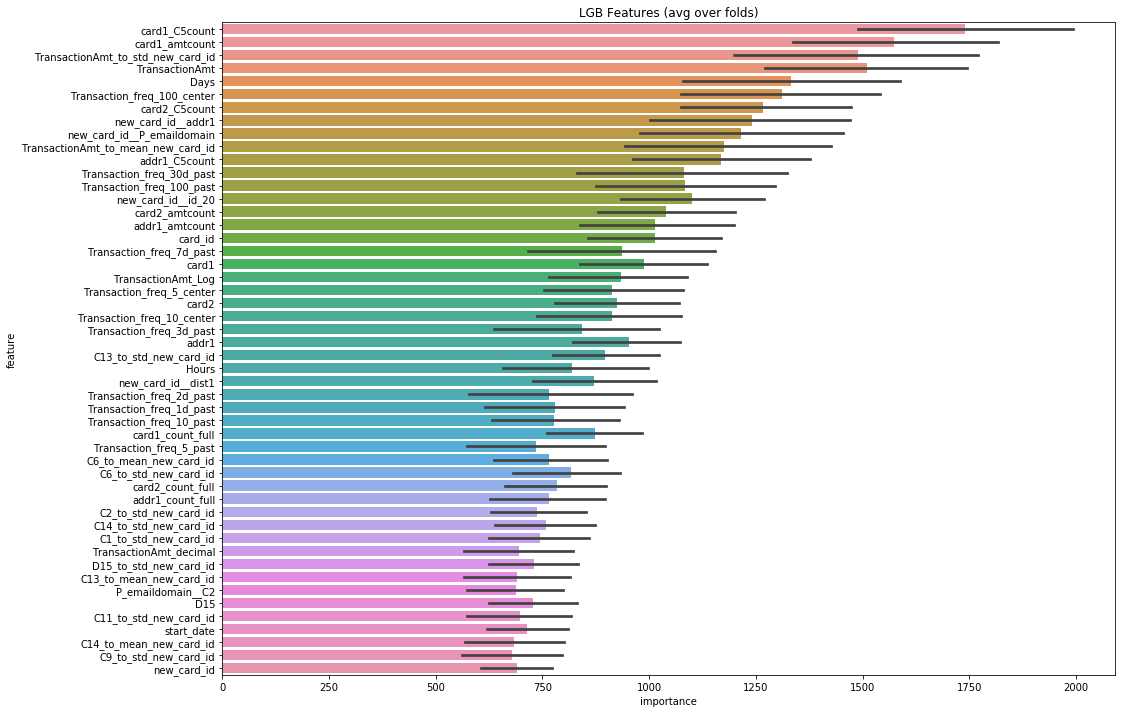

In [9]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 6
folds = GroupKFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_pca_nouid = train_model_classification(X=train.drop('DT_M', axis=1), X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=train['DT_M'])

In [10]:
pd.DataFrame(result_pca_nouid['oof'], columns=['isFraud'], index=train.index).to_csv('oof_result_pca_nouid.csv')
pd.DataFrame(result_pca_nouid['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_result_pca_nouid.csv')
pd.DataFrame(result_pca_nouid['scores'], columns=['cv']).to_csv('scores_result_pca_nouid.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_pca_nouid['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_pca_nouid.csv')

##### submit 9498: aggs some c4, c9, all c5, c8; timefreq; PCA Vs; new dataset 09457; all sample

Fold 1 started at Sat Sep 28 14:57:41 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997381	training's auc: 0.997381	valid_1's auc: 0.91453	valid_1's auc: 0.91453
[1000]	training's auc: 0.999985	training's auc: 0.999985	valid_1's auc: 0.919281	valid_1's auc: 0.919281
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.920145	valid_1's auc: 0.920145
Early stopping, best iteration is:
[1490]	training's auc: 1	training's auc: 1	valid_1's auc: 0.920203	valid_1's auc: 0.920203
Fold 2 started at Sat Sep 28 15:34:10 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997573	training's auc: 0.997573	valid_1's auc: 0.939434	valid_1's auc: 0.939434
[1000]	training's auc: 0.999993	training's auc: 0.999993	valid_1's auc: 0.944895	valid_1's auc: 0.944895
Early stopping, best iteration is:
[1269]	training's auc: 1	training's auc: 1	valid_1's auc: 0.945498	valid_1's auc: 0.945498
Fold 3 started at Sat Sep 28 

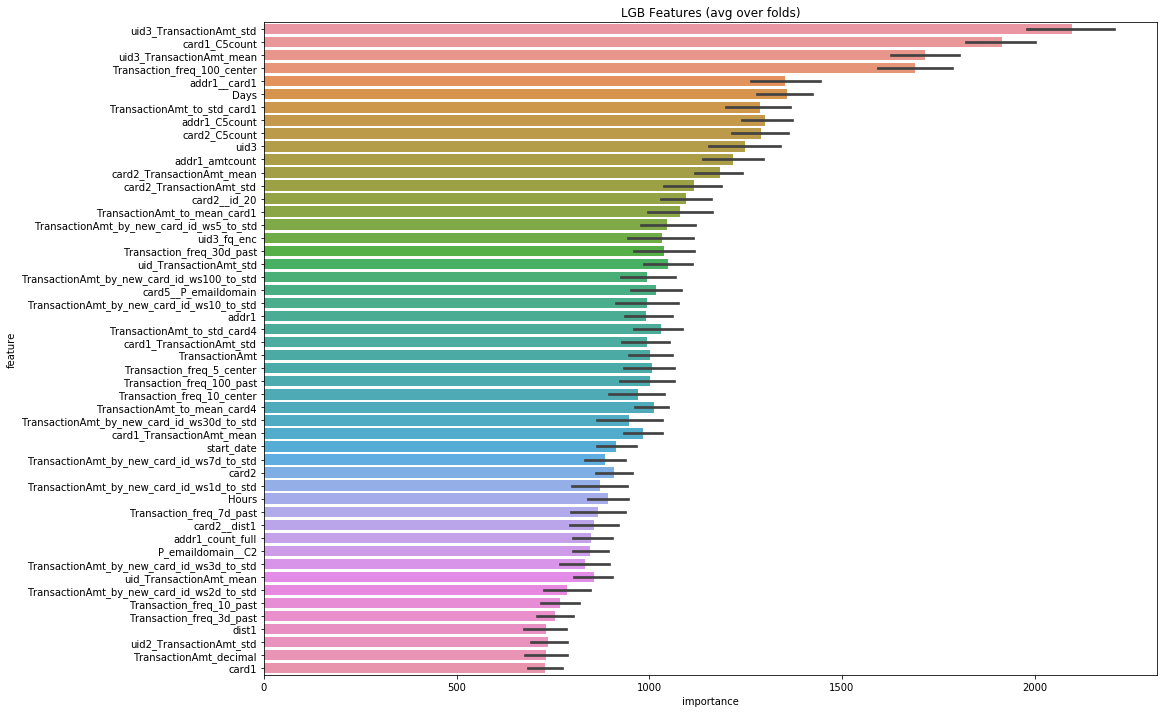

In [28]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_pca = train_model_classification(X=train, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [29]:
pd.DataFrame(result_pca['oof'], columns=['isFraud'], index=train.index).to_csv('oof_result_pca.csv')
pd.DataFrame(result_pca['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_result_pca.csv')
pd.DataFrame(result_pca['scores'], columns=['cv']).to_csv('scores_result_pca.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_pca['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_pca.csv')

##### downsample 94.75: all aggs; new 09457; best aggs (not all c5, c8); time freq

In [237]:
train_pos = train[train['isFraud']==1]
train_neg = train[train['isFraud']==0]
train_neg = train_neg.sample(int(train_neg.shape[0] * 0.2), random_state=0)

down = pd.concat([train_pos,train_neg]).sort_index().drop('isFraud', axis=1)
del train_pos, train_neg
gc.collect()

14

Fold 1 started at Sat Sep 28 13:14:01 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997015	training's auc: 0.997015	valid_1's auc: 0.909229	valid_1's auc: 0.909229
[1000]	training's auc: 0.999981	training's auc: 0.999981	valid_1's auc: 0.914482	valid_1's auc: 0.914482
Early stopping, best iteration is:
[1165]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.914719	valid_1's auc: 0.914719
Fold 2 started at Sat Sep 28 13:25:18 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997099	training's auc: 0.997099	valid_1's auc: 0.938348	valid_1's auc: 0.938348
[1000]	training's auc: 0.999989	training's auc: 0.999989	valid_1's auc: 0.944762	valid_1's auc: 0.944762
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.946022	valid_1's auc: 0.946022
Early stopping, best iteration is:
[1433]	training's auc: 1	training's auc: 1	valid_1's auc: 0.945928	valid_1's auc: 0.945928
Fold 3 starte

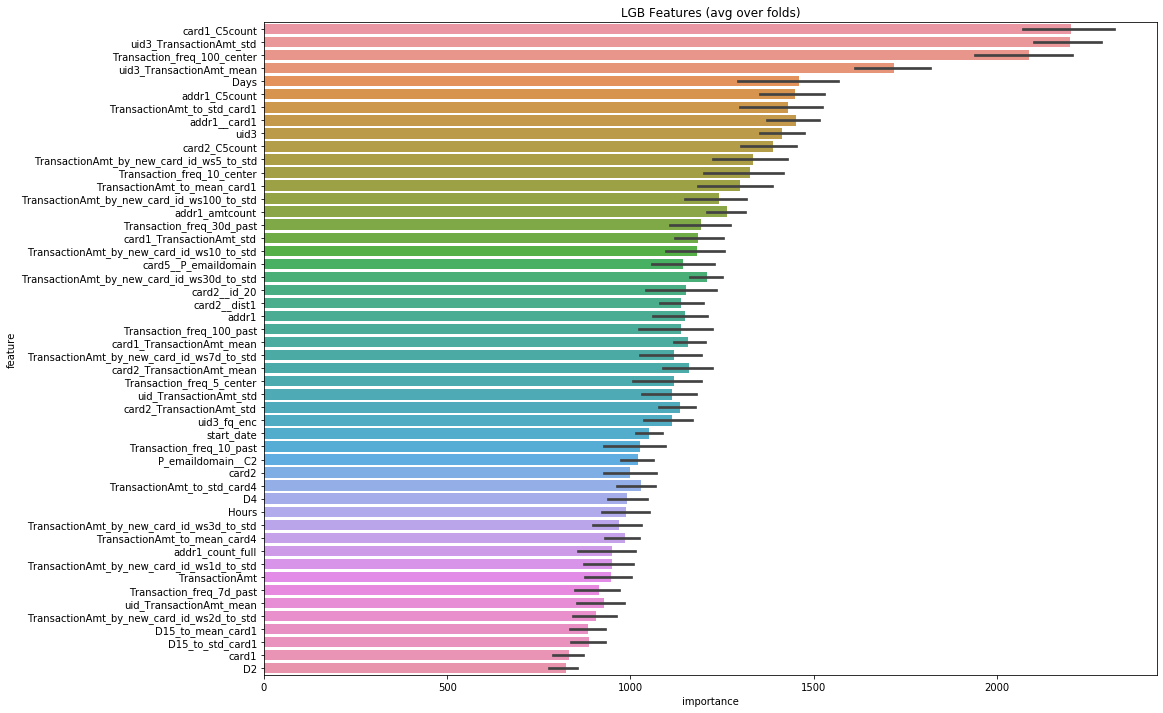

In [239]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new09457_timefreq_someaggs = train_model_classification(X=down, X_test=test, y=y.loc[down.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [241]:
pd.DataFrame(result_new09457_timefreq_someaggs['oof'], columns=['isFraud'], index=down.index).to_csv('oof_new09457_timefreq_someaggs.csv')
pd.DataFrame(result_new09457_timefreq_someaggs['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_new09457_timefreq_someaggs.csv')
pd.DataFrame(result_new09457_timefreq_someaggs['scores'], columns=['cv']).to_csv('scores_new09457_timefreq_someaggs.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')
sample_submission['isFraud'] = pd.DataFrame(result_new09457_timefreq_someaggs['prediction'], columns=['isFraud'], index=test.index)
sample_submission.to_csv('lgb_new09457_timefreq_someaggs.csv')

##### all aggs no freq - no submit

Fold 1 started at Thu Sep 26 22:52:58 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997591	training's auc: 0.997591	valid_1's auc: 0.908546	valid_1's auc: 0.908546
[1000]	training's auc: 0.999955	training's auc: 0.999955	valid_1's auc: 0.914129	valid_1's auc: 0.914129
Early stopping, best iteration is:
[1251]	training's auc: 0.999994	training's auc: 0.999994	valid_1's auc: 0.914766	valid_1's auc: 0.914766
Fold 2 started at Thu Sep 26 23:34:35 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997878	training's auc: 0.997878	valid_1's auc: 0.933059	valid_1's auc: 0.933059
[1000]	training's auc: 0.999968	training's auc: 0.999968	valid_1's auc: 0.937834	valid_1's auc: 0.937834
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.938369	valid_1's auc: 0.938369
Early stopping, best iteration is:
[1498]	training's auc: 1	training's auc: 1	valid_1's auc: 0.938375	valid_1's auc: 0.938375
Fold 3 starte

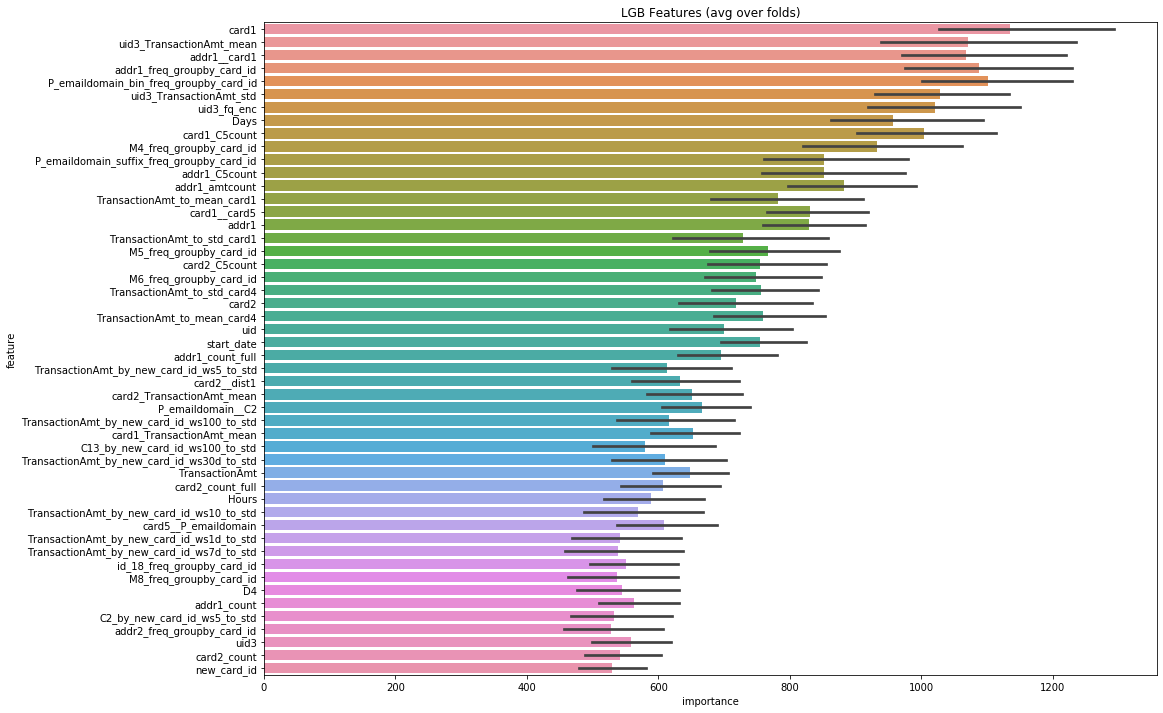

In [103]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_timefreq_timeaggs = train_model_classification(X=train, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [ ]:
pd.DataFrame(result_timefreq_timeaggs['oof'], columns=['isFraud'], index=train.index).to_csv('oof_all_data_best_lgb_timefreq_timeaggs.csv')
pd.DataFrame(result_timefreq_timeaggs['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_all_data_best_lgb_timefreq_timeaggs.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_timefreq_timeaggs['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_timefreq_timeaggs.csv')

##### best submit 95.04: time freq, new card id, aggs tr amt, c5, c8; old 09457; all sample

Fold 1 started at Tue Sep 24 23:40:26 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997214	training's auc: 0.997214	valid_1's auc: 0.90802	valid_1's auc: 0.90802
[1000]	training's auc: 0.999946	training's auc: 0.999946	valid_1's auc: 0.912926	valid_1's auc: 0.912926
[1500]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.914081	valid_1's auc: 0.914081
Early stopping, best iteration is:
[1521]	training's auc: 1	training's auc: 1	valid_1's auc: 0.914102	valid_1's auc: 0.914102
Fold 2 started at Wed Sep 25 02:48:34 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.99751	training's auc: 0.99751	valid_1's auc: 0.935922	valid_1's auc: 0.935922
[1000]	training's auc: 0.99996	training's auc: 0.99996	valid_1's auc: 0.940048	valid_1's auc: 0.940048
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.940394	valid_1's auc: 0.940394
Early stopping, best iteration is:
[1389]	training's a

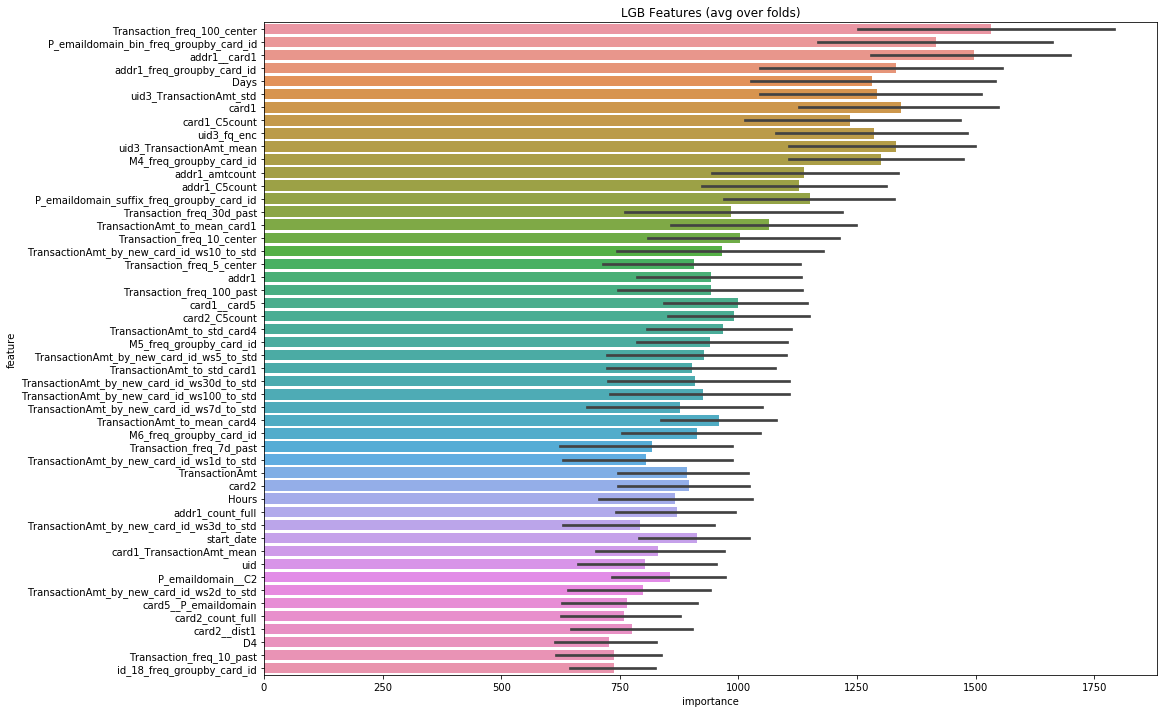

In [49]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_timefreq = train_model_classification(X=train, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [50]:
pd.DataFrame(result_timefreq['oof'], columns=['isFraud'], index=train.index).to_csv('oof_all_data_best_lgb_timefreq.csv')
pd.DataFrame(result_timefreq['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_all_data_best_lgb_timefreq.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_timefreq['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_timefreq.csv')

###### submit 94.96

Fold 1 started at Tue Sep 24 08:07:46 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997	training's auc: 0.997	valid_1's auc: 0.907724	valid_1's auc: 0.907724
[1000]	training's auc: 0.999939	training's auc: 0.999939	valid_1's auc: 0.912574	valid_1's auc: 0.912574
Early stopping, best iteration is:
[1228]	training's auc: 0.999988	training's auc: 0.999988	valid_1's auc: 0.913188	valid_1's auc: 0.913188
Fold 2 started at Tue Sep 24 08:42:17 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997289	training's auc: 0.997289	valid_1's auc: 0.934262	valid_1's auc: 0.934262
[1000]	training's auc: 0.999953	training's auc: 0.999953	valid_1's auc: 0.938965	valid_1's auc: 0.938965
[1500]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.939626	valid_1's auc: 0.939626
[2000]	training's auc: 1	training's auc: 1	valid_1's auc: 0.939774	valid_1's auc: 0.939774
Early stopping, best iteration is:
[2282

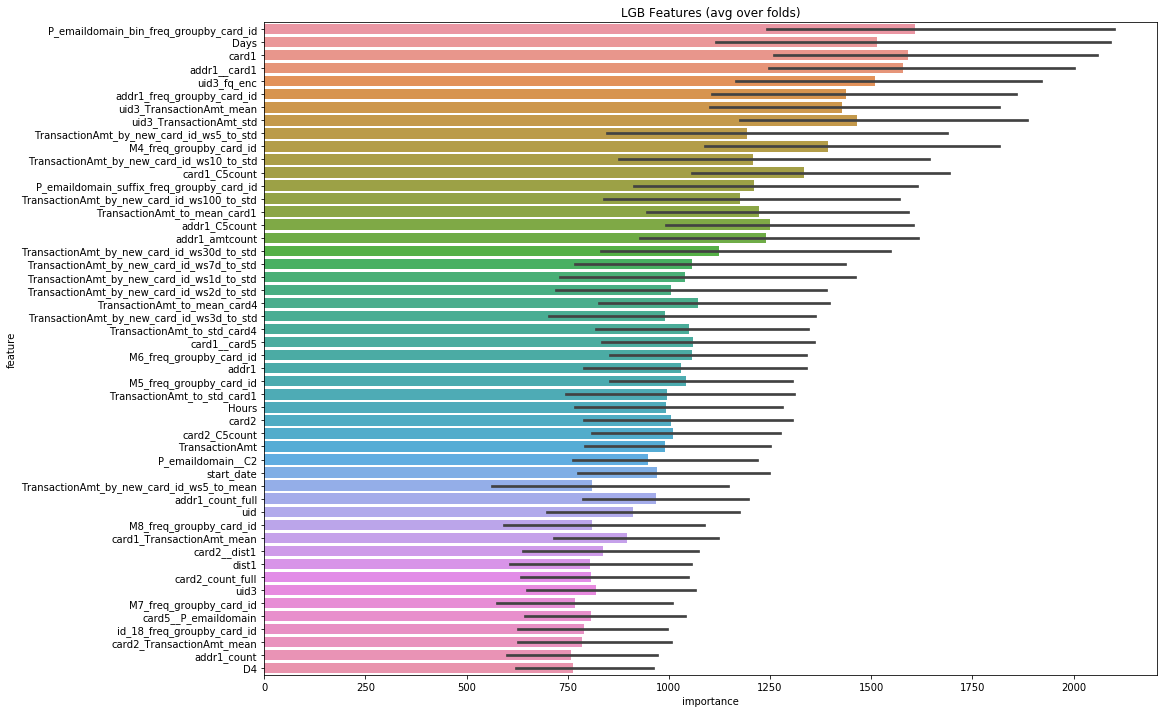

In [34]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_card_id = train_model_classification(X=train, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [40]:
result_new_card_id['feature_importance'].sort_values(by='importance', ascending=False).iloc[:70]

,feature,importance,fold
575,P_emaildomain_bin_freq_groupby_card_id,2575.800000000000182,2
433,Days,2548.400000000000091,2
2,card1,2512.800000000000182,2
478,addr1__card1,2394.400000000000091,2
552,uid3_fq_enc,2303.400000000000091,2
573,addr1_freq_groupby_card_id,2251.400000000000091,2
511,uid3_TransactionAmt_mean,2245.199999999999818,2
512,uid3_TransactionAmt_std,2202.400000000000091,2
647,TransactionAmt_by_new_card_id_ws5_to_std,2178.599999999999909,2
581,M4_freq_groupby_card_id,2146.599999999999909,2


In [41]:
pd.DataFrame(result_new_card_id['oof'], columns=['isFraud'], index=train.index).to_csv('oof_all_data_best_lgb_plus_start_date_new_id.csv')
pd.DataFrame(result_new_card_id['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_all_data_best_lgb_plus_start_date_new_id.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_card_id['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_new_card_id_best_submit_plus_start_date_new_id.csv')

##### submit 94.84

Fold 1 started at Sun Sep 22 23:19:26 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.996951	training's auc: 0.996951	valid_1's auc: 0.907434	valid_1's auc: 0.907434
[1000]	training's auc: 0.999935	training's auc: 0.999935	valid_1's auc: 0.912558	valid_1's auc: 0.912558
Early stopping, best iteration is:
[1247]	training's auc: 0.999989	training's auc: 0.999989	valid_1's auc: 0.913015	valid_1's auc: 0.913015
Fold 2 started at Sun Sep 22 23:52:34 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.997295	training's auc: 0.997295	valid_1's auc: 0.933983	valid_1's auc: 0.933983
[1000]	training's auc: 0.999955	training's auc: 0.999955	valid_1's auc: 0.938119	valid_1's auc: 0.938119
[1500]	training's auc: 1	training's auc: 1	valid_1's auc: 0.938696	valid_1's auc: 0.938696
Early stopping, best iteration is:
[1607]	training's auc: 1	training's auc: 1	valid_1's auc: 0.938751	valid_1's auc: 0.938751
Fold 3 starte

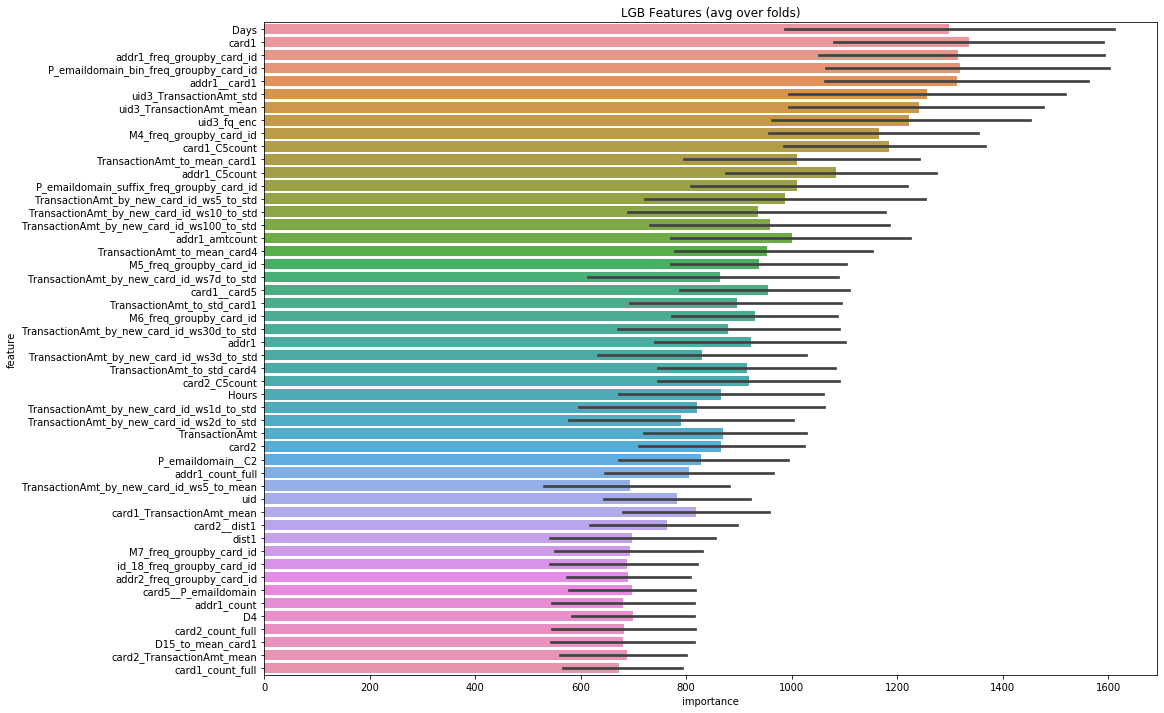

In [140]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_card_id = train_model_classification(X=train, X_test=test, y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [141]:
pd.DataFrame(result_new_card_id['oof'], columns=['isFraud'], index=train.index).to_csv('oof_all_data_best_lgb.csv')
pd.DataFrame(result_new_card_id['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_all_data_best_lgb.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_card_id['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_new_card_id_best_submit.csv')

##### experiments

Fold 1 started at Sun Sep 22 18:14:54 2019
Training until validation scores don't improve for 1000 rounds.
[100]	training's auc: 0.952841	training's auc: 0.952841	valid_1's auc: 0.87923	valid_1's auc: 0.87923
[200]	training's auc: 0.964317	training's auc: 0.964317	valid_1's auc: 0.885559	valid_1's auc: 0.885559
[300]	training's auc: 0.973487	training's auc: 0.973487	valid_1's auc: 0.890489	valid_1's auc: 0.890489
[400]	training's auc: 0.97999	training's auc: 0.97999	valid_1's auc: 0.895259	valid_1's auc: 0.895259
[500]	training's auc: 0.98496	training's auc: 0.98496	valid_1's auc: 0.899929	valid_1's auc: 0.899929
[600]	training's auc: 0.987973	training's auc: 0.987973	valid_1's auc: 0.903198	valid_1's auc: 0.903198
[700]	training's auc: 0.989933	training's auc: 0.989933	valid_1's auc: 0.905915	valid_1's auc: 0.905915
[800]	training's auc: 0.991346	training's auc: 0.991346	valid_1's auc: 0.908153	valid_1's auc: 0.908153
[900]	training's auc: 0.992621	training's auc: 0.992621	valid_1's a

[2700]	training's auc: 0.99988	training's auc: 0.99988	valid_1's auc: 0.941468	valid_1's auc: 0.941468
[2800]	training's auc: 0.999912	training's auc: 0.999912	valid_1's auc: 0.941436	valid_1's auc: 0.941436
[2900]	training's auc: 0.999938	training's auc: 0.999938	valid_1's auc: 0.941423	valid_1's auc: 0.941423
[3000]	training's auc: 0.999954	training's auc: 0.999954	valid_1's auc: 0.941485	valid_1's auc: 0.941485
[3100]	training's auc: 0.999967	training's auc: 0.999967	valid_1's auc: 0.941475	valid_1's auc: 0.941475
[3200]	training's auc: 0.999976	training's auc: 0.999976	valid_1's auc: 0.941488	valid_1's auc: 0.941488
[3300]	training's auc: 0.999983	training's auc: 0.999983	valid_1's auc: 0.94155	valid_1's auc: 0.94155
[3400]	training's auc: 0.999989	training's auc: 0.999989	valid_1's auc: 0.941488	valid_1's auc: 0.941488
[3500]	training's auc: 0.999992	training's auc: 0.999992	valid_1's auc: 0.941502	valid_1's auc: 0.941502
[3600]	training's auc: 0.999994	training's auc: 0.999994	va

[3300]	training's auc: 0.999984	training's auc: 0.999984	valid_1's auc: 0.953895	valid_1's auc: 0.953895
[3400]	training's auc: 0.999989	training's auc: 0.999989	valid_1's auc: 0.953921	valid_1's auc: 0.953921
[3500]	training's auc: 0.999992	training's auc: 0.999992	valid_1's auc: 0.95394	valid_1's auc: 0.95394
[3600]	training's auc: 0.999995	training's auc: 0.999995	valid_1's auc: 0.953931	valid_1's auc: 0.953931
[3700]	training's auc: 0.999996	training's auc: 0.999996	valid_1's auc: 0.953863	valid_1's auc: 0.953863
[3800]	training's auc: 0.999997	training's auc: 0.999997	valid_1's auc: 0.953798	valid_1's auc: 0.953798
[3900]	training's auc: 0.999998	training's auc: 0.999998	valid_1's auc: 0.953808	valid_1's auc: 0.953808
[4000]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.953837	valid_1's auc: 0.953837
[4100]	training's auc: 0.999999	training's auc: 0.999999	valid_1's auc: 0.953849	valid_1's auc: 0.953849
[4200]	training's auc: 0.999999	training's auc: 0.999999	

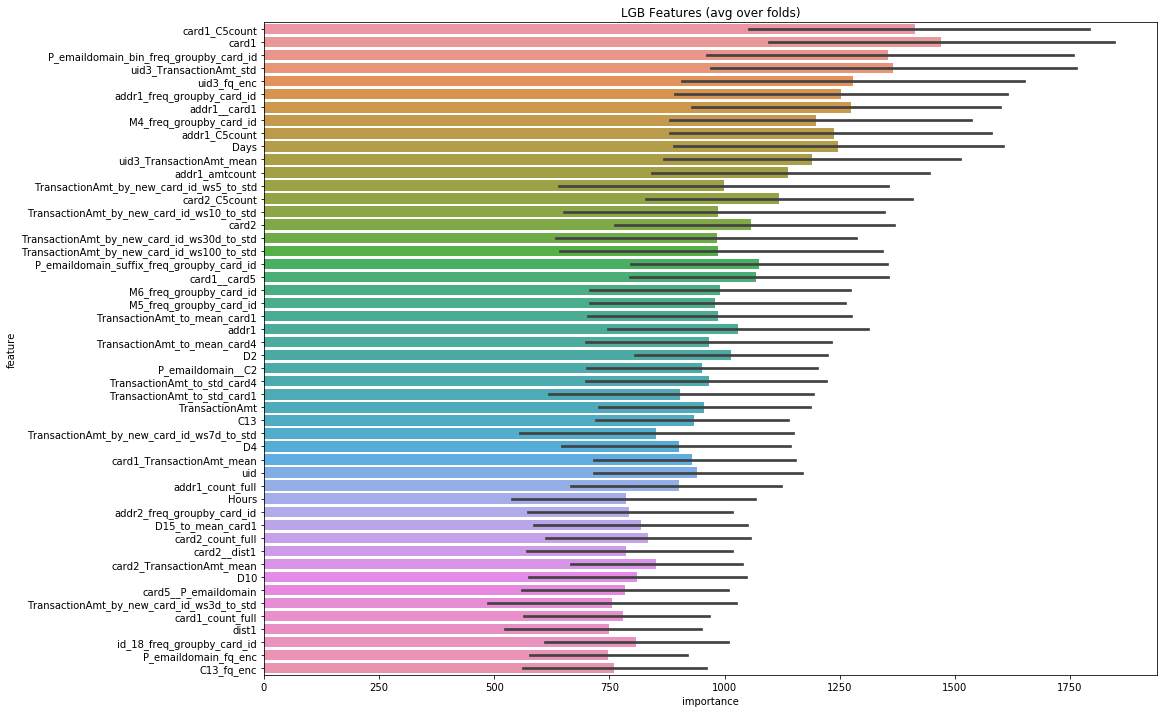

In [41]:
params = {'num_leaves': 400,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': 15,
          'max_bin': 100,
          'learning_rate': 0.007,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
#           'reg_alpha': 0.3899927210061127,
#           'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 1000,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_card_id_wo_DT_no_overfit = train_model_classification(X=down, X_test=test, y=y.loc[down.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [38]:
sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_card_id_wo_DT_no_overfit['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_new_card_id_del_no_overfit_v4.csv')

Fold 1 started at Sun Sep 22 16:15:29 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999988	training's auc: 0.999988	valid_1's auc: 0.912464	valid_1's auc: 0.912464
Early stopping, best iteration is:
[713]	training's auc: 1	training's auc: 1	valid_1's auc: 0.912916	valid_1's auc: 0.912916
Fold 2 started at Sun Sep 22 16:22:36 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999994	training's auc: 0.999994	valid_1's auc: 0.941559	valid_1's auc: 0.941559
Early stopping, best iteration is:
[727]	training's auc: 1	training's auc: 1	valid_1's auc: 0.942281	valid_1's auc: 0.942281
Fold 3 started at Sun Sep 22 16:29:53 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999993	training's auc: 0.999993	valid_1's auc: 0.935935	valid_1's auc: 0.935935
Early stopping, best iteration is:
[693]	training's auc: 1	training's auc: 1	valid_1's auc: 0.936716	valid_1's auc: 0.93

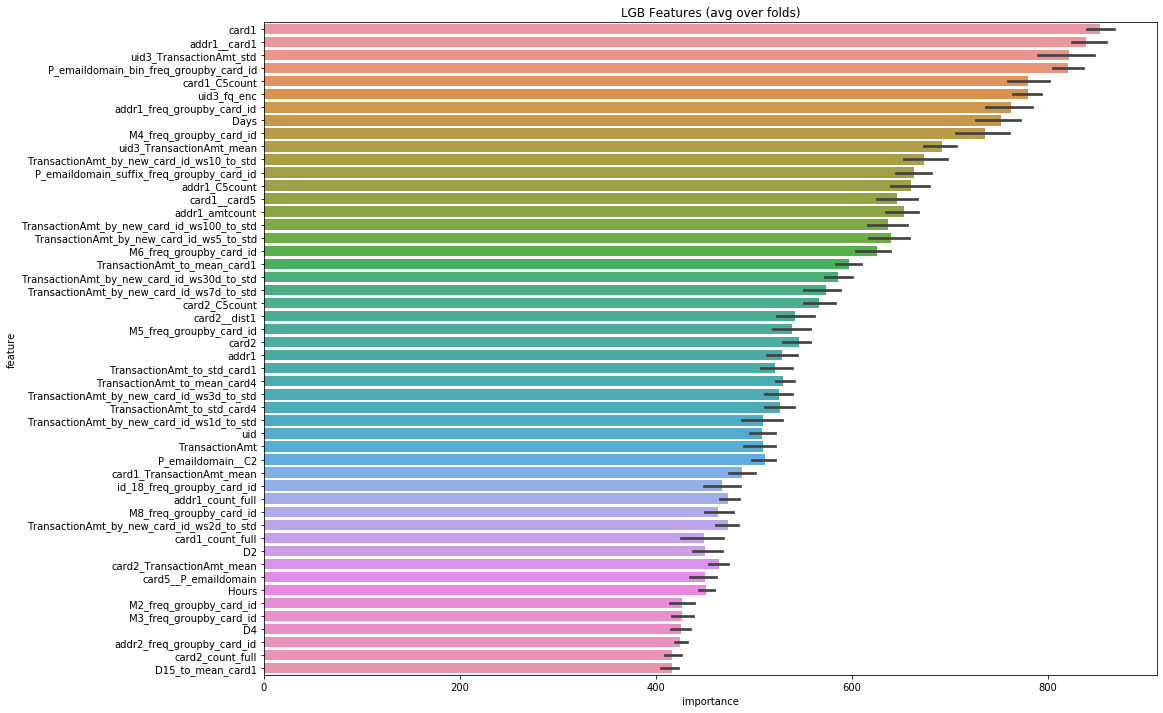

In [32]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_card_id_wo_DT = train_model_classification(X=down, X_test=test, y=y.loc[down.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [33]:
sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_card_id_wo_DT['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_new_card_id_del_mean020_v3.csv')

In [44]:
pd.DataFrame(result_new_card_id_wo_DT['oof'], columns=['isFraud'], index=down.index).to_csv('oof_lgb_new_card_id_del_mean020_v3.csv')

Fold 1 started at Sun Sep 22 15:35:54 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.99999	training's auc: 0.99999	valid_1's auc: 0.909457	valid_1's auc: 0.909457
Early stopping, best iteration is:
[702]	training's auc: 1	training's auc: 1	valid_1's auc: 0.910381	valid_1's auc: 0.910381
Fold 2 started at Sun Sep 22 15:43:14 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999996	training's auc: 0.999996	valid_1's auc: 0.941887	valid_1's auc: 0.941887
Early stopping, best iteration is:
[672]	training's auc: 1	training's auc: 1	valid_1's auc: 0.943079	valid_1's auc: 0.943079
Fold 3 started at Sun Sep 22 15:50:20 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999995	training's auc: 0.999995	valid_1's auc: 0.936641	valid_1's auc: 0.936641
Early stopping, best iteration is:
[686]	training's auc: 1	training's auc: 1	valid_1's auc: 0.937355	valid_1's auc: 0.9373

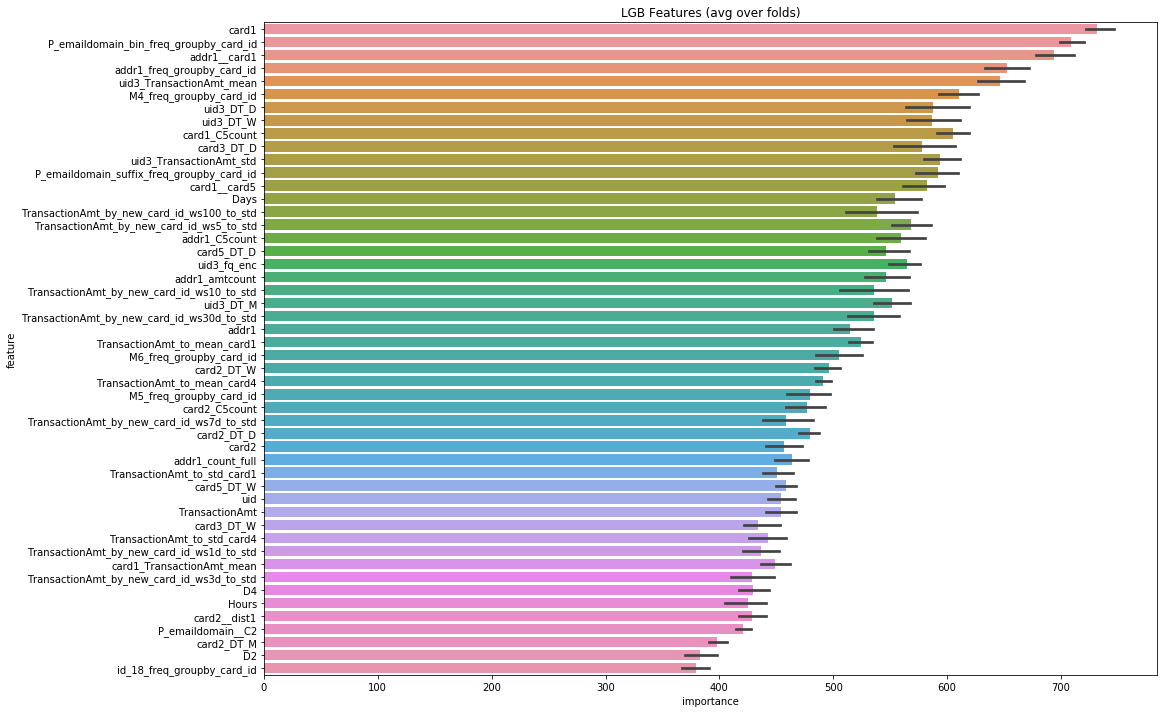

In [26]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,
          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_new_card_id = train_model_classification(X=down, X_test=test, y=y.loc[down.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [27]:
sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_new_card_id['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_new_card_id_del_mean020_v2.csv')

In [4]:
# train_ = pd.read_csv(data_path +  'X_score_agg.csv').set_index('TransactionID')
# test_ = pd.read_csv(data_path + 'test_aggs.csv').set_index('TransactionID')

In [175]:
# rocs = pd.read_csv('f:\my\Prog\kaggle\Baydin\Data\individual_auc_from_aggregates.csv')

# rocs.sort_values(by=[' auc'], ascending=False)

# rocfeat = rocs.sort_values(by=[' auc'], ascending=False).iloc[:11].drop(0)['feature_name'].tolist()

# train_ = train_[rocfeat]
# test_ = test_[rocfeat]

In [9]:
# train_.drop('score', axis=1, inplace=True)

X = pd.concat([train, train_], axis=1)#.drop('isFraud', axis=1)
del train, train_
gc.collect()

testall = pd.concat([test, test_], axis=1)#.drop('isFraud', axis=1)

del test_
gc.collect()

# testall.drop('Date', axis=1, inplace=True)
testall.drop(3577539, inplace=True)

In [11]:
X = X.loc[:,~X.columns.duplicated()]
testall = testall.loc[:,~testall.columns.duplicated()]

In [12]:
print(X.shape, testall.shape)

(590540, 651) (506691, 650)


In [14]:
train_pos = X[X['isFraud']==1]
train_neg = X[X['isFraud']==0]

train_neg = train_neg.sample(int(X.shape[0] * 0.2), random_state=0)

d0 = pd.concat([train_pos,train_neg]).sort_index()
d0.drop(['Date', 'isFraud'], axis=1, inplace=True)

del train_pos, train_neg
gc.collect()

7

In [15]:
testall.drop(['Date'], axis=1, inplace=True)

In [16]:
print(d0.shape, testall.shape)

(138771, 682) (506691, 682)


In [17]:
d0.drop([x for x in X.columns if x.startswith('DT')] + ['TransactionDT'], axis=1, inplace=True)

testall.drop([x for x in X.columns if x.startswith('DT')] + ['TransactionDT'], axis=1, inplace=True)

d0.drop(['Days'], axis=1, inplace=True)

testall.drop(['Days'], axis=1, inplace=True)

Fold 1 started at Sat Sep 21 14:20:39 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999984	training's auc: 0.999984	valid_1's auc: 0.911897	valid_1's auc: 0.911897
Early stopping, best iteration is:
[682]	training's auc: 1	training's auc: 1	valid_1's auc: 0.912623	valid_1's auc: 0.912623
Fold 2 started at Sat Sep 21 14:27:49 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999991	training's auc: 0.999991	valid_1's auc: 0.941419	valid_1's auc: 0.941419
Early stopping, best iteration is:
[764]	training's auc: 1	training's auc: 1	valid_1's auc: 0.942401	valid_1's auc: 0.942401
Fold 3 started at Sat Sep 21 14:35:32 2019
Training until validation scores don't improve for 200 rounds.
[500]	training's auc: 0.999991	training's auc: 0.999991	valid_1's auc: 0.93606	valid_1's auc: 0.93606
Early stopping, best iteration is:
[762]	training's auc: 1	training's auc: 1	valid_1's auc: 0.93687	valid_1's auc: 0.93687

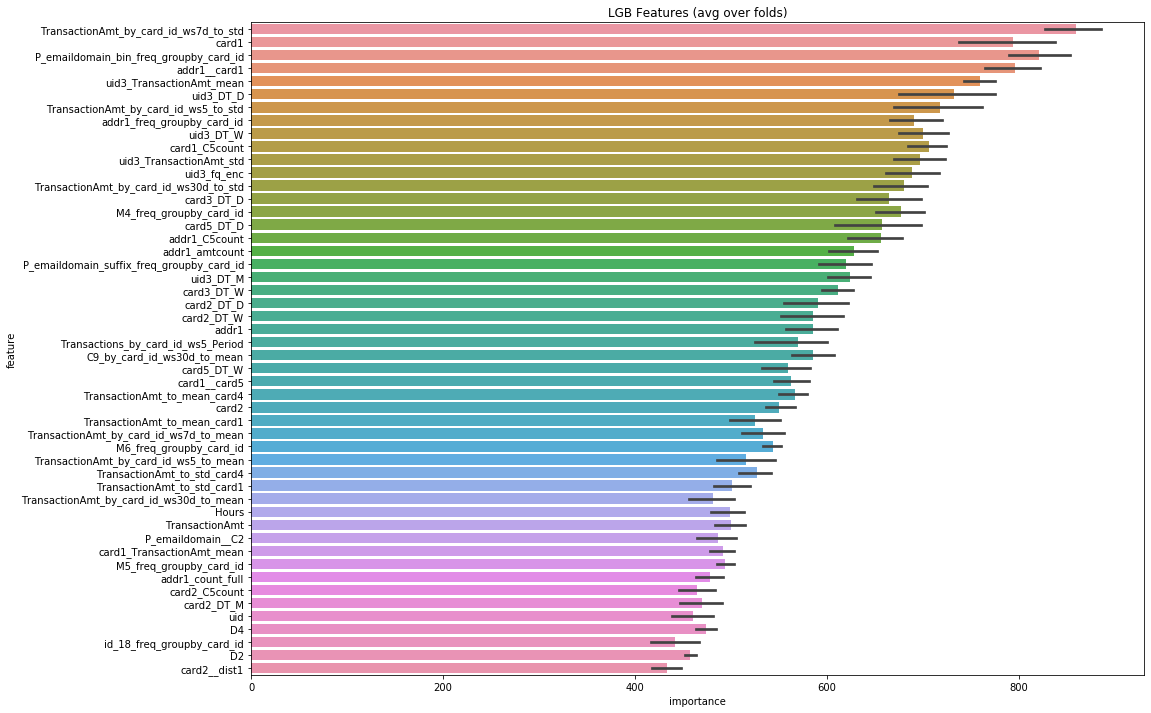

In [24]:
params = {'num_leaves': 491,
          'min_child_weight': 0.03454472573214212,
          'feature_fraction': 0.3797454081646243,
          'bagging_fraction': 0.4181193142567742,
          'min_data_in_leaf': 106,

          'objective': 'binary',
          'max_depth': -1,
          'learning_rate': 0.02,
          "boosting_type": "gbdt",
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": -1,
          'reg_alpha': 0.3899927210061127,
          'reg_lambda': 0.6485237330340494,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 200,
    'n_estimators': 10000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold}

result_dict_lgb = train_model_classification(X=d0, X_test=testall, y=y.loc[d0.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             eval_metric=train_options['eval_metric'],
                                             plot_feature_importance=True,
                                             verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

In [27]:
result_dict_lgb

{'oof': array([[0.00300991],
        [0.00761982],
        [0.034926  ],
        ...,
        [0.01280509],
        [0.03292795],
        [0.0148177 ]]), 'prediction': array([[0.00142633],
        [0.00373419],
        [0.00566684],
        ...,
        [0.00348286],
        [0.00877833],
        [0.0116643 ]]), 'scores': [0.9126165093147816,
  0.9423995647539873,
  0.936863609351813,
  0.9534606263531548,
  0.9317837544815138], 'feature_importance':             feature           importance  fold
 0    TransactionAmt  474.000000000000000     1
 1         ProductCD   29.399999999999999     1
 2             card1  694.600000000000023     1
 3             card2  527.399999999999977     1
 4             card3    6.600000000000000     1
 ..              ...                  ...   ...
 669   card5_C5count  107.000000000000000     5
 670  addr1_amtcount  637.600000000000023     5
 671   addr1_C5count  661.000000000000000     5
 672  addr2_amtcount    1.000000000000000     5
 673   addr2_C5cou

In [57]:
roc_auc_score(y.loc[d0.index], result_dict_lgb['oof'])

0.9353689444581904

In [28]:
pd.DataFrame(result_dict_lgb['oof']).to_pickle('res_lgb_21_09_oof.pkl')
pd.DataFrame(result_dict_lgb['prediction']).to_pickle('res_lgb_21_09_prediction.pkl')

In [29]:
pd.DataFrame(result_dict_lgb['prediction'], columns=['isFraud'], index=test.index)

,isFraud
TransactionID,
3663549,0.001426326474054
3663550,0.003734193332406
3663551,0.005666839079386
3663552,0.002013196822285
3663553,0.001578808345772
3663554,0.001647390942125
3663555,0.010613231629927
3663556,0.020501283243511
3663557,0.000597706258702


In [30]:
sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_dict_lgb['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('lgb_feats_highest_individual_roc_no_dt.csv')

# Keras

In [31]:
main_folder = r'f:/my/prog/kaggle/Stacking_data'
# model_folder = r'../../Snapshots/Stacking/06.09'

In [32]:
import os
L = os.listdir(main_folder)

oof = pd.DataFrame(index=X.index)
prediction = pd.DataFrame(index=testall.index)

for experiment_name in L:
    
    experiment_folder = os.path.join(main_folder,experiment_name)
    
    if not os.path.exists(f'{experiment_folder}/results_dict.pkl'):
        continue
        
        
    results_dict = pd.read_pickle(f'{experiment_folder}/results_dict.pkl')
    
#     print(experiment_name, sum(results_dict['scores'])/len(results_dict['scores']))
    
    oof[experiment_name] = results_dict['oof'][:,0]
    prediction[experiment_name] = results_dict['prediction'][:,0]

# Catboost

In [ ]:
nans_groups = {}
temp_df = train.isna()
temp_df2 = test.isna()

nans_df = pd.concat([temp_df, temp_df2])

for col in list(nans_df):
    cur_group = nans_df[col].sum()
    if cur_group>0:
        try:
            nans_groups[cur_group].append(col)
        except:
            nans_groups[cur_group]=[col]

add_category = []
for col in nans_groups:
    if len(nans_groups[col])>1:
        train['nan_group_'+str(col)] = np.where(temp_df[nans_groups[col]].sum(axis=1)>0,1,0).astype(np.int8)
        test['nan_group_'+str(col)]  = np.where(temp_df2[nans_groups[col]].sum(axis=1)>0,1,0).astype(np.int8)
        add_category.append('nan_group_'+str(col))
        
del temp_df, temp_df2, nans_df, nans_groups

categorical_features = ['ProductCD','M4',
                        'card1','card2','card3','card4','card5','card6',
                        'addr1','addr2','dist1','dist2',
                        'P_emaildomain','R_emaildomain',
                       ]
categorical_features += add_category

total_items = len(train)
keep_cols = ['isFraud','C3_fq_enc']

for col in list(train):
    if train[col].dtype.name!='category':
        cur_dominator = list(train[col].fillna(-999).value_counts())[0]
        if (cur_dominator/total_items > 0.85) and (col not in keep_cols):
            cur_dominator = train[col].fillna(-999).value_counts().index[0]
            print('Column:', col, ' | Dominator:', cur_dominator)
            train[col] = np.where(train[col].fillna(-999)==cur_dominator,1,0)
            test[col] = np.where(test[col].fillna(-999)==cur_dominator,1,0)

            train[col] = train[col].fillna(-999).astype(int)
            test[col] = test[col].fillna(-999).astype(int)

            if col not in categorical_features:
                categorical_features.append(col)
                
categorical_features +=['D8_not_same_day','TransactionAmt_check']

restore_features = ['uid','uid2','uid3']

for col in restore_features:
    categorical_features.append(col)

cols_sum = {}
bad_types = ['datetime64[ns]', 'category','object']

for col in list(train):
    if train[col].dtype.name not in bad_types:
        cur_col = train[col].values
        cur_sum = cur_col.mean()
        try:
            cols_sum[cur_sum].append(col)
        except:
            cols_sum[cur_sum] = [col]

cols_sum = {k:v for k,v in cols_sum.items() if len(v)>1}   

for k,v in cols_sum.items():
    for col in v[1:]:
        if train[v[0]].equals(train[col]):
            print('Duplicate', col)
            del train[col], test[col]

features_columns = [col for col in list(train)]
categorical_features = [col for col in categorical_features if col in features_columns]

In [34]:
categorical_features.append('new_card_id')

In [22]:
import catboost as cb
from catboost import CatBoostClassifier

# params = {
#           'grow_policy':'Lossguide',
#            'max_leaves':400,
#            'od_type':'Iter',
#            'depth':8,
#           'verbose':100,
# #         'eval_metric': 'AUC',
#           'metric_period': 500,
#         'od_wait': 500,
#           'objective': 'Logloss',
#           'learning_rate': 0.07,
# #           'loss_function':'Logloss',
#           'use_best_model':True,
# #           "logging_level": 'Verbose',
#           'random_state': 0,
# #           'bootstrap_type': 'Bayesian',
#           'task_type': 'GPU',
# #         'num_rounds':800
#          }
params = {
#                 'n_estimators':5000,
                'learning_rate': 0.07,
                'eval_metric':'AUC',
                'loss_function':'Logloss',
                'random_seed':42,
                'metric_period':500,
                'od_wait':500,
                'task_type':'GPU',
                'depth': 8,
                #'colsample_bylevel':0.7,
                } 
n_fold = 6
folds = GroupKFold(n_splits=n_fold)
train_options = {
    "model_type":'cat',
    "params": params,
    'early_stopping_rounds': 1000,
    'n_estimators': 5000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
    
}

In [29]:
result_dict_cb_new_id = train_model_classification_vb(X=train.drop('DT_M', axis=1), X_test=test,
                                                   y=y, params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             categorial_columns = categorical_features,
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=train['DT_M'])

Fold 1 started at Sun Sep 29 17:08:15 2019
0:	learn: 0.8514085	test: 0.7168265	best: 0.7168265 (0)	total: 220ms	remaining: 18m 22s
500:	learn: 0.9733300	test: 0.9116689	best: 0.9116689 (500)	total: 1m 40s	remaining: 15m 6s
1000:	learn: 0.9805996	test: 0.9174764	best: 0.9176021 (994)	total: 3m 20s	remaining: 13m 19s
1500:	learn: 0.9854490	test: 0.9194227	best: 0.9197925 (1387)	total: 4m 55s	remaining: 11m 27s
2000:	learn: 0.9889560	test: 0.9203175	best: 0.9203175 (2000)	total: 6m 28s	remaining: 9m 42s
2500:	learn: 0.9917231	test: 0.9206296	best: 0.9208584 (2328)	total: 8m 3s	remaining: 8m 3s
bestTest = 0.9208583534
bestIteration = 2328
Shrink model to first 2329 iterations.
Fold 2 started at Sun Sep 29 17:19:45 2019
0:	learn: 0.8655457	test: 0.8106072	best: 0.8106072 (0)	total: 210ms	remaining: 17m 31s
500:	learn: 0.9711381	test: 0.9463339	best: 0.9463339 (500)	total: 1m 38s	remaining: 14m 48s
1000:	learn: 0.9784264	test: 0.9483573	best: 0.9484090 (983)	total: 3m 16s	remaining: 13m 4s
1

In [60]:
train['dist1'] = train['dist1'].fillna(-999).astype(int)
test['dist1'] = test['dist1'].fillna(-999).astype(int)

categorical_features.remove('dist1')

In [69]:
train[categorical_features].replace(np.inf, -999, inplace=True)
train[categorical_features].replace(-np.inf, -999, inplace=True)
train[categorical_features].replace(np.nan, -999, inplace=True)

test[categorical_features].replace(np.inf, -999, inplace=True)
test[categorical_features].replace(-np.inf, -999, inplace=True)
test[categorical_features].replace(np.nan, -999, inplace=True)


In [70]:
NFOLDS = 6
folds = GroupKFold(n_splits=NFOLDS)

X = train.drop('DT_M', axis=1)  

test['predictions'] = 0
split_groups = train['DT_M']

oof = np.zeros(len(train))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y, groups=split_groups)):
    print('Fold:',fold_)

    estimator = CatBoostClassifier(**params)        
    estimator.fit(
        
        X.iloc[trn_idx,:],y.iloc[trn_idx],
        eval_set=(X.iloc[val_idx,:], y.iloc[val_idx]),
        cat_features=categorical_features,
        use_best_model=True,
        verbose=True)

    oof_preds = estimator.predict_proba(X.iloc[val_idx,:])[:,1]
    oof[val_idx] = (oof_preds - oof_preds.min())/(oof_preds.max() - oof_preds.min())
    test['predictions'] += estimator.predict_proba(test)[:,1]/NFOLDS

Fold: 0
0:	learn: 0.9024795	test: 0.7923290	best: 0.7923290 (0)	total: 244ms	remaining: 4m 3s
500:	learn: 0.9769291	test: 0.9256505	best: 0.9256593 (499)	total: 1m 35s	remaining: 1m 34s
999:	learn: 0.9825804	test: 0.9308411	best: 0.9308432 (994)	total: 3m 9s	remaining: 0us
bestTest = 0.9308432341
bestIteration = 994
Shrink model to first 995 iterations.


CatBoostError: bad allocation

In [58]:
del sub1, sample_submission
gc.collect()

21682

In [36]:
print('OOF AUC:', metrics.roc_auc_score(y, oof))

Fold: 0


KeyError: "None of [Int64Index([134339, 134340, 134341, 134342, 134343, 134344, 134345, 134346,\n            134347, 134348,\n            ...\n            590530, 590531, 590532, 590533, 590534, 590535, 590536, 590537,\n            590538, 590539],\n           dtype='int64', name='TransactionID', length=456201)] are in the [index]"

In [31]:
pd.DataFrame(result_dict_cb_new_id['oof'], columns=['isFraud'], index=train.index).to_csv('oof_cb.csv')
pd.DataFrame(result_dict_cb_new_id['prediction'], columns=['isFraud'], index=test.index).to_csv('prediction_cb.csv')
# pd.DataFrame(result_dict_cb_new_id['scores'], columns=['cv']).to_csv('scores_result_cb.csv')

sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_dict_cb_new_id['prediction'], columns=['isFraud'], index=test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('cb_best.csv')

# XGB

In [101]:
import xgboost as xgb
params = {'num_leaves': 400,
          
          'max_depth': 13,
          'subsample': 0.9,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
            'colsample_bytree':0.9,
            'tree_method': 'gpu_hist',
          "eval_metric": 'auc',
          "verbosity": 2,
          'random_state': 47, 
         }

n_fold = 5
folds = KFold(n_splits=n_fold)
train_options = {
    "model_type":'xgb',
    "params": params,
    'early_stopping_rounds': 100,
    'n_estimators': 5000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
    
}

In [102]:
result_dict_xgb = train_model_classification(X=down, X_test=test, y=y.loc[down.index], params=params, folds=folds,
                                             model_type=train_options['model_type'], 
                                             plot_feature_importance=True,
                                             verbose=100, early_stopping_rounds=train_options['early_stopping_rounds'],
                                             n_estimators=train_options['n_estimators'], 
                                             averaging=train_options['averaging'],
                                             n_jobs=-1, groups=None)

[21:23:01] ======== Monitor:  ========
Fold 1 started at Sun Sep 22 21:23:01 2019
[0]	train-auc:0.880089	valid_data-auc:0.802546
Multiple eval metrics have been passed: 'valid_data-auc' will be used for early stopping.

Will train until valid_data-auc hasn't improved in 400 rounds.
[100]	train-auc:0.92857	valid_data-auc:0.865077
[200]	train-auc:0.948142	valid_data-auc:0.877981
[300]	train-auc:0.962556	valid_data-auc:0.888015
[400]	train-auc:0.974786	valid_data-auc:0.895246
[500]	train-auc:0.981924	valid_data-auc:0.898973
[600]	train-auc:0.986941	valid_data-auc:0.901467
[700]	train-auc:0.990096	valid_data-auc:0.903242
[800]	train-auc:0.992362	valid_data-auc:0.904199
[900]	train-auc:0.99405	valid_data-auc:0.904742
[1000]	train-auc:0.995323	valid_data-auc:0.905262
[1100]	train-auc:0.996477	valid_data-auc:0.905341
[1200]	train-auc:0.997316	valid_data-auc:0.905731
[1300]	train-auc:0.997928	valid_data-auc:0.905938
[1400]	train-auc:0.998376	valid_data-auc:0.906092
[1500]	train-auc:0.998744	va

KeyboardInterrupt: 

# Stacking val

In [189]:
pd.DataFrame(result_dict_cb['oof'], columns=['isFraud'], index=X_train.index)

,isFraud
TransactionID,
2987000,0.039141712764465
2987001,0.015548221715198
2987002,0.013103215338967
2987003,0.016900947736608
2987004,0.006705534285556
2987005,0.006277400978427
2987006,0.008981095622524
2987007,0.036694767515166
2987008,0.002423828583111


In [ ]:
dfstacked = pd.concat([pd.DataFrame(oof['keras-4'].loc[d0.index]),
pd.DataFrame(result_dict_lgb['oof'], columns=['lgb'], index=d0.index),
pd.DataFrame(result_dict_cb['oof'], columns=['catboost'], index=X_train.index).loc[d0.index]          
          
          ], axis=1)

In [198]:
teststacked = pd.concat([pd.DataFrame(prediction['keras-4'], index=testall.index),
pd.DataFrame(result_dict_lgb['prediction'], columns=['lgb'], index=testall.index),
pd.DataFrame(result_dict_cb['prediction'], columns=['catboost'], index=X_test.index).loc[testall.index]            
          
          ], axis=1)
teststacked

,keras-4,lgb,catboost
TransactionID,,,
3663549,0.001185184717178,0.001426326474054,0.001300035270837
3663550,0.000768280029297,0.003734193332406,0.004229734433507
3663551,0.000193744897842,0.005666839079386,0.005286646110784
3663552,0.000861740112305,0.002013196822285,0.002485959925723
3663553,0.001589679718018,0.001578808345772,0.002139836802640
3663554,0.002420610189438,0.001647390942125,0.005690339617626
3663555,0.001774120330811,0.010613231629927,0.017623435694178
3663556,0.005303895473480,0.020501283243511,0.037336123294135
3663557,0.001584178209305,0.000597706258702,0.001107533178182


Fold 1 started at Sat Sep 21 19:42:06 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's binary_logloss: 0.286292	training's auc: 0.951298	valid_1's binary_logloss: 0.245723	valid_1's auc: 0.930882
[1000]	training's binary_logloss: 0.231164	training's auc: 0.951695	valid_1's binary_logloss: 0.208805	valid_1's auc: 0.931314
[1500]	training's binary_logloss: 0.204816	training's auc: 0.95191	valid_1's binary_logloss: 0.192579	valid_1's auc: 0.932083
[2000]	training's binary_logloss: 0.191415	training's auc: 0.952051	valid_1's binary_logloss: 0.185541	valid_1's auc: 0.932041
Early stopping, best iteration is:
[1621]	training's binary_logloss: 0.200708	training's auc: 0.951906	valid_1's binary_logloss: 0.190286	valid_1's auc: 0.93239
Fold 2 started at Sat Sep 21 19:43:49 2019
Training until validation scores don't improve for 500 rounds.
[500]	training's binary_logloss: 0.271335	training's auc: 0.94579	valid_1's binary_logloss: 0.29583	valid_1's auc: 0.9524

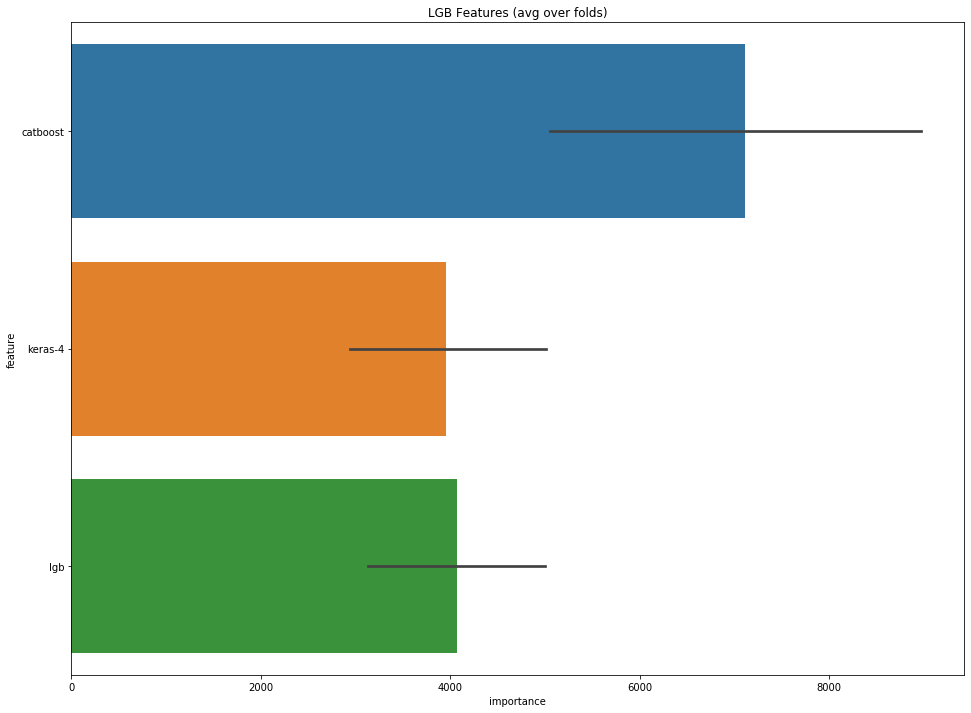

In [199]:
params = {
    'learning_rate': 0.001,
    'num_leaves': 100,
    'max_depth': 300,
    'min_child_weight': 2,
    'lambda_l1':1,
    'lambda_l2':2,
    'min_data_in_leaf' :20,
    'min_sum_hessian_in_leaf' : 0.0001,
    'max_bin': 12,
    'min_gain_to_split': 0.1 }

train_options = {
    "model_type":'lgb',
    "params": params,
    "eval_metric":'auc',
    'early_stopping_rounds': 500,
    'n_estimators': 5000,
    'averaging': 'usual',
    'use_groups': False,
    'fold_name': folds.__class__.__name__,
    'n_splits': n_fold
}


result_dict_stack = train_model_classification(X=dfstacked, X_test=teststacked, y=y.loc[d0.index], params=params, folds=folds,
                                         model_type=train_options['model_type'], 
                                         eval_metric=train_options['eval_metric'],
                                         plot_feature_importance=True,
                                         verbose=500, early_stopping_rounds=train_options['early_stopping_rounds'],
                                         n_estimators=train_options['n_estimators'], 
                                         averaging=train_options['averaging'],
                                         n_jobs=-1, groups=None)

In [200]:
print("debug:",roc_auc_score(y_test, pd.DataFrame(result_dict_stack['oof'], index=d0.index).loc[X_test.index]))

KeyError: "None of [Int64Index([3663549, 3663550, 3663551, 3663552, 3663553, 3663554, 3663555,\n            3663556, 3663557, 3663558,\n            ...\n            4170230, 4170231, 4170232, 4170233, 4170234, 4170235, 4170236,\n            4170237, 4170238, 4170239],\n           dtype='int64', name='TransactionID', length=506691)] are in the [index]"

In [201]:
# 0.9460
result_dict_stack

{'oof': array([[0.03494401],
        [0.03818893],
        [0.09631046],
        ...,
        [0.08278048],
        [0.14938253],
        [0.06906683]]), 'prediction': array([[0.04425361],
        [0.04607702],
        [0.04703524],
        ...,
        [0.05848709],
        [0.0527526 ],
        [0.05113073]]), 'scores': [0.9317251708595375,
  0.9531073426857004,
  0.9467103667827439,
  0.959826851586238,
  0.9412036202632642], 'feature_importance':     feature             importance  fold
 0   keras-4   4688.199999999999818     1
 1       lgb   4552.000000000000000     1
 2  catboost   7897.600000000000364     1
 0   keras-4   5807.399999999999636     2
 1       lgb   5734.600000000000364     2
 2  catboost  10564.200000000000728     2
 0   keras-4   2409.400000000000091     3
 1       lgb   2287.800000000000182     3
 2  catboost   4074.599999999999909     3
 0   keras-4   2777.199999999999818     4
 1       lgb   3347.199999999999818     4
 2  catboost   5111.600000000000364     4


In [202]:
roc_auc_score(y.loc[d0.index], result_dict_stack['oof'])

0.9395873874401879

In [204]:
sample_submission = pd.read_csv(data_path + 'sample_submission.csv').set_index('TransactionID')

sub1 = pd.DataFrame(result_dict_stack['prediction'], columns=['isFraud'], index=X_test.index)

sample_submission['isFraud'] = sub1#*0.5 + sub2*0.25 + sub3*0.25

sample_submission.to_csv('stacking_keras_lightgbm_catboost.csv')

In [74]:
split_pos = d0.shape[0]*4//5
y_test = y.loc[d0.index].iloc[split_pos:]
y_train = y.loc[d0.index].iloc[:split_pos]
X_test = d0.iloc[split_pos:,:]
X_train = d0.iloc[:split_pos,:]

In [67]:
X_train

,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,...,card1_amtcount,card1_C5count,card2_amtcount,card2_C5count,card5_amtcount,card5_C5count,addr1_amtcount,addr1_C5count,addr2_amtcount,addr2_C5count
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987005,49.00000000,4,5937.0,555.0,150.0,4,226.0,2,272.0,87.0,...,143.125000,NaN,126.06250,0.542818662032301,141.8750,0.658403644996400,132.00000,0.510700706092290,148.25000,0.688490397991455
2987013,40.00000000,4,12866.0,303.0,150.0,4,226.0,2,330.0,87.0,...,109.687500,0.358581331043800,111.75000,0.353910100219402,141.8750,0.658403644996400,132.00000,0.429791256488607,148.25000,0.688490397991455
2987019,186.00000000,4,7005.0,111.0,150.0,4,226.0,2,264.0,87.0,...,105.812500,1.299192138706477,150.50000,0.825433854819450,141.8750,0.658403644996400,148.75000,1.207152047454066,148.25000,0.688490397991455
2987023,107.93750000,4,2392.0,360.0,150.0,2,166.0,2,126.0,87.0,...,98.125000,1.219938448947579,97.75000,0.863463363208763,98.7500,0.766795844897551,166.25000,0.319081106291291,148.25000,0.688490397991455
2987029,37.00000000,4,12932.0,361.0,150.0,4,226.0,2,204.0,87.0,...,135.125000,0.487115831719213,151.87500,0.492135252343489,141.8750,0.658403644996400,152.00000,0.558586685288245,148.25000,0.688490397991455
2987031,364.00000000,4,6573.0,583.0,150.0,4,226.0,1,315.0,87.0,...,152.875000,0.437445319335083,230.87500,0.257895296752350,141.8750,0.658403644996400,135.62500,1.344081189563054,148.25000,0.688490397991455
2987032,200.00000000,4,7835.0,361.0,150.0,4,226.0,2,472.0,87.0,...,154.625000,0.641903598950512,151.87500,0.492135252343489,141.8750,0.658403644996400,175.50000,0.341763207652762,148.25000,0.688490397991455
2987037,21.95312500,4,13249.0,111.0,150.0,4,226.0,2,264.0,87.0,...,120.312500,1.247310510639275,150.50000,0.825433854819450,141.8750,0.658403644996400,148.75000,1.207152047454066,148.25000,0.688490397991455
2987046,49.00000000,4,12544.0,321.0,150.0,4,226.0,2,441.0,87.0,...,110.875000,0.837046545518747,133.37500,0.862709486514745,141.8750,0.658403644996400,123.37500,0.511935109270232,148.25000,0.688490397991455


# Blend

In [62]:
df9506 = pd.read_csv('9506_ensemble.csv')

In [79]:
df9506.set_index('TransactionID', inplace=True)

In [99]:
blend = df9506.copy()

In [107]:
sub1 = pd.DataFrame(result_dict_lgb['prediction'], columns=['lgb'], index=blend.index)['lgb']

In [108]:
sub2 = blend['isFraud']

In [109]:
blend['isFraud'] = sub1*0.5 + sub2*0.5

In [110]:
blend.to_csv('blend1.csv')